
--- HHL Algorithm Results (Based on the Paper) ---
Counts (filtered for ancilla=1): {'0': 480, '1': 4612}
Measured probability ratio of |x₁|² to |x₀|²: 9.61 : 1
Expected ratio: 9.00 : 1

--- Quantum Circuit Diagram ---


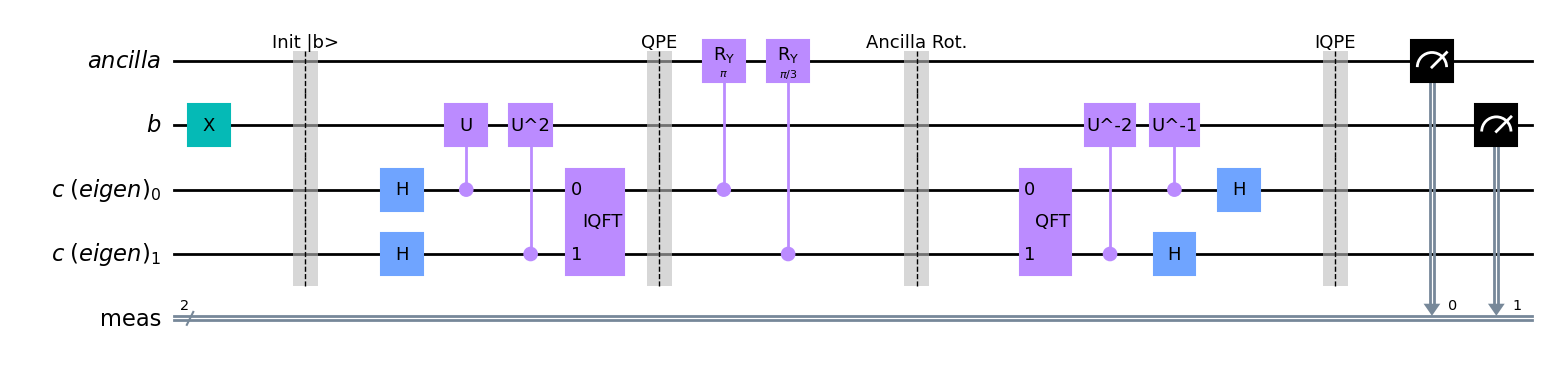

In [8]:
# %matplotlib inline directive for notebook environments
%matplotlib inline

import numpy as np
from numpy import pi
import matplotlib.pyplot as plt

# Qiskit imports
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit.circuit.library import QFT, RYGate
from qiskit.circuit import Gate
from qiskit.primitives import Sampler
from qiskit_aer.primitives import Sampler as AerSampler

# =================================================================
# MAIN HHL CIRCUIT CONSTRUCTION (Based on the paper by Zaman et al.)
# =================================================================
def get_paper_hhl_circuit():
    """
    Constructs the 4-qubit HHL circuit as described in the paper
    "A Step-by-Step HHL Algorithm Walkthrough...".
    """
    # --- Register Setup (4 qubits total) ---
    ancilla = AncillaRegister(1, name="ancilla")
    b_register = QuantumRegister(1, name="b")
    c_register = QuantumRegister(2, name="c (eigen)")
    cr = ClassicalRegister(2, name="meas")
    qc = QuantumCircuit(ancilla, b_register, c_register, cr)

    # --- Step 1: State Preparation ---
    # To prepare |b> = |1>, we apply an X gate.
    qc.x(b_register)
    qc.barrier(label="Init |b>")

    # --- Step 2: Quantum Phase Estimation (QPE) ---
    qc.h(c_register)

    # Define the controlled-U gates from the paper's matrices (Eq. 36 & 37)
    U_matrix = (1/2) * np.array([[-1+1j, 1+1j], [1+1j, -1+1j]])
    U_gate = Gate(name="U", num_qubits=1, params=[])
    U_gate.definition = QuantumCircuit(1)
    U_gate.definition.unitary(U_matrix, [0])
    
    U2_matrix = np.array([[0, -1], [-1, 0]]) # This is -X gate
    U2_gate = Gate(name="U^2", num_qubits=1, params=[])
    U2_gate.definition = QuantumCircuit(1)
    U2_gate.definition.unitary(U2_matrix, [0])

    qc.append(U_gate.control(1), [c_register[0], b_register[0]])
    qc.append(U2_gate.control(1), [c_register[1], b_register[0]])
    
    qc.append(QFT(2, inverse=True, name="IQFT"), c_register)
    qc.barrier(label="QPE")

    # --- Step 3: Controlled Rotation of Ancilla ---
    qc.cry(pi, c_register[0], ancilla[0])
    qc.cry(pi/3, c_register[1], ancilla[0])
    qc.barrier(label="Ancilla Rot.")
    
    # --- Step 4: Inverse QPE ---
    qc.append(QFT(2, name="QFT"), c_register)

    U_inv_gate = Gate(name="U^-1", num_qubits=1, params=[])
    U_inv_gate.definition = QuantumCircuit(1)
    U_inv_gate.definition.unitary(U_matrix.conj().T, [0])
    
    U2_inv_gate = Gate(name="U^-2", num_qubits=1, params=[])
    U2_inv_gate.definition = QuantumCircuit(1)
    U2_inv_gate.definition.unitary(U2_matrix.conj().T, [0])
    
    qc.append(U2_inv_gate.control(1), [c_register[1], b_register[0]])
    qc.append(U_inv_gate.control(1), [c_register[0], b_register[0]])

    qc.h(c_register)
    qc.barrier(label="IQPE")

    # --- Step 5: Measurement ---
    # Measure ancilla to classical bit 0, and b to classical bit 1
    qc.measure(ancilla, cr[0])
    qc.measure(b_register, cr[1])
    
    return qc

# --- Circuit Construction & Execution ---
hhl_circuit = get_paper_hhl_circuit()
sampler = AerSampler()
job = sampler.run(hhl_circuit, shots=8192)
result = job.result()
# FIX: Use the modern way to get results from the Sampler
quasi_dist = result.quasi_dists[0]
shots = 8192

# --- Result Processing ---
solution_counts = {'0': 0, '1': 0}

# Iterate through the probability distribution
for outcome_int, prob in quasi_dist.items():
    # Convert the integer outcome to a binary string
    # Our classical register 'meas' has 2 bits
    state = f'{outcome_int:02b}'
    
    # The string is 'c1 c0' -> b_bit is c1, ancilla_bit is c0
    b_bit, ancilla_bit = state[0], state[1]
    
    if ancilla_bit == '1':
        # Add the approximate number of shots to our counts
        solution_counts[b_bit] += prob * shots

# --- Final Output Section ---
print("\n--- HHL Algorithm Results (Based on the Paper) ---")
print(f"Counts (filtered for ancilla=1): {{'0': {solution_counts.get('0', 0):.0f}, '1': {solution_counts.get('1', 0):.0f}}}")

prob_0 = solution_counts.get('0', 0)
prob_1 = solution_counts.get('1', 0)
if prob_0 > 0:
    ratio = prob_1 / prob_0
    print(f"Measured probability ratio of |x₁|² to |x₀|²: {ratio:.2f} : 1")
    print(f"Expected ratio: 9.00 : 1")
else:
    print("No |0> states measured for the solution vector.")

# --- Visualization ---
print("\n--- Quantum Circuit Diagram ---")
hhl_circuit.draw('mpl', style='clifford')
plt.show()